# Imports

In [329]:
import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

# Load data

Dataset Reference: https://archive.ics.uci.edu/dataset/102/thyroid+disease

In [330]:
# Load the .mat file
file_path = '/content/drive/MyDrive/Dataset/thyroid.mat'  # Update with the correct path to your .mat file
mat_contents = scipy.io.loadmat(file_path)

# Inspect the contents to find the key containing the data
print(mat_contents.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])


In [331]:
# Assume the main data is under a key named 'data' (you need to update this based on actual contents)
data_key = 'X'  # Update this with the correct key
data = mat_contents[data_key]

# Target value
target_key = 'y'
target = mat_contents[target_key]

# Convert the target array to integers
target = target.astype(int)

In [332]:
# If the data is a structured array, convert it directly to a DataFrame
dataframe = pd.DataFrame(data)
dataframe.columns = ['Attribute1', 'Attribute2', 'Attribute3', 'Attribute4',
                     'Attribute5', 'Attribute6']

dataframe['Class'] = target

dataframe.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Class
0,0.774194,0.001132,0.137571,0.275701,0.295775,0.236066,0
1,0.247312,0.000472,0.279886,0.329439,0.535211,0.173770,0
2,0.494624,0.003585,0.222960,0.233645,0.525822,0.124590,0
3,0.677419,0.001698,0.156546,0.175234,0.333333,0.136066,0
4,0.236559,0.000472,0.241935,0.320093,0.333333,0.247541,0


# Analysis & Formating

In [333]:
dataframe.Class.value_counts()

Class
0    3679
1      93
Name: count, dtype: int64

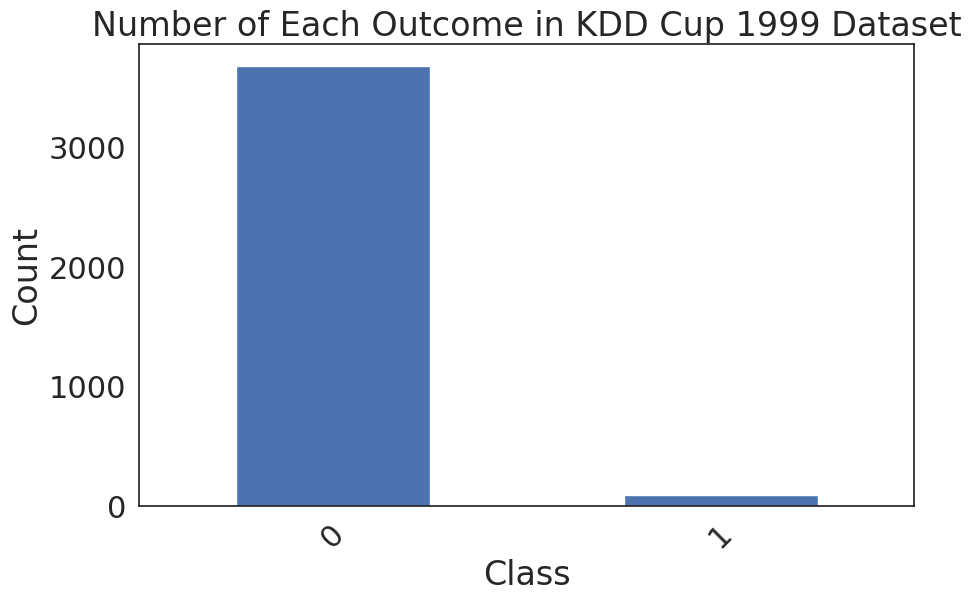

In [334]:
# Draw a graph showing the distribution of class
outcome_counts = dataframe['Class'].value_counts()

plt.figure(figsize=(10, 6))
outcome_counts.plot(kind='bar')
plt.title('Number of Each Outcome in KDD Cup 1999 Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [335]:
## separate the Fraud and the Normal dataset for future reference
Anomaly = dataframe[dataframe['Class'] == 1]
Normal = dataframe[dataframe['Class'] == 0]

print("Shape of Anomaly and Normal Datasets: ", Anomaly.shape, Normal.shape)

# Find the ration of Outlier to Normal
outlier_fraction = len(Anomaly)/float(len(Normal))

print("Fraction of outlier to normal: ",outlier_fraction)

Shape of Anomaly and Normal Datasets:  (93, 7) (3679, 7)
Fraction of outlier to normal:  0.025278608317477577


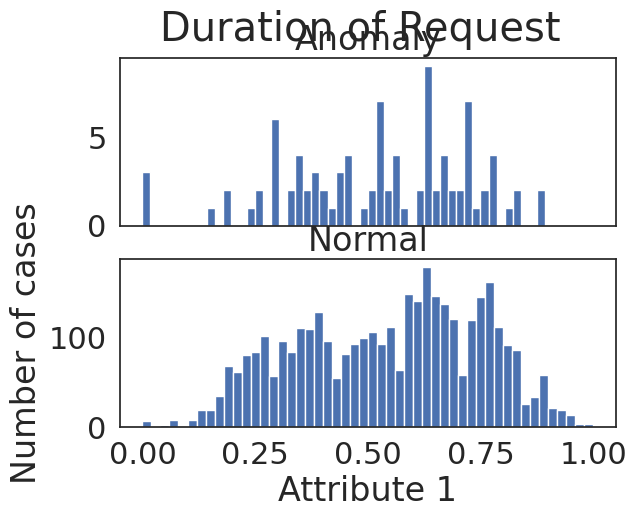

In [336]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Duration of Request')
ax1.hist(Anomaly.Attribute1, bins=50)
ax1.set_title('Anomaly')
ax2.hist(Normal.Attribute1, bins=50)
ax2.set_title('Normal')
plt.xlabel('Attribute 1')
plt.ylabel('Number of cases')
# make the y-axis unit in logarithmic scale
plt.show()

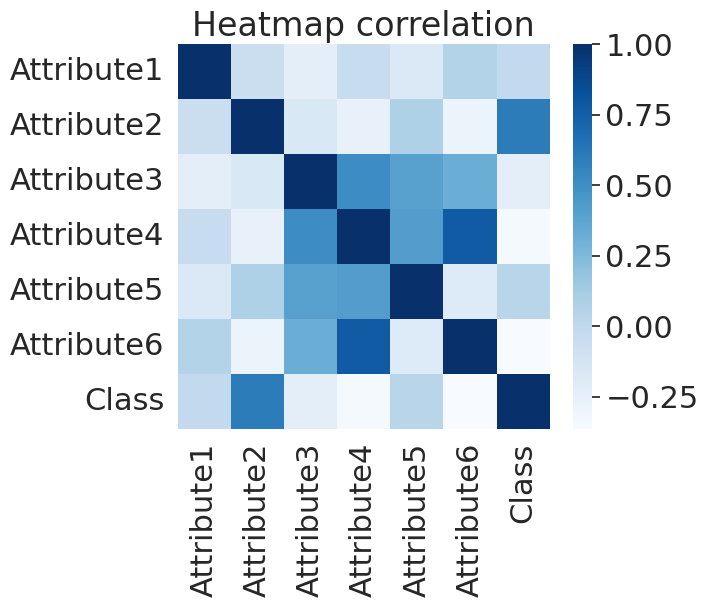

In [337]:
import seaborn

df_corr = dataframe.corr()

plt.figure(figsize=(6,5))
seaborn.heatmap(df_corr, cmap='Blues')
seaborn.set(font_scale=2,style='white')

plt.title('Heatmap correlation')
plt.show()

# Useful Functions

In [338]:
# When given the actual class and predicted class it plots confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Anomaly Detection

## PCA

In [36]:
df = dataframe.copy()

In [37]:
df.shape

(3772, 7)

In [38]:
# Separate the dataset into normal and anomaly
df_normal = df[df['Class'] == 0]
df_anomaly = df[df['Class'] == 1]

In [39]:
# Separate features and target variable
X = dataframe.drop('Class', axis=1)
y = dataframe['Class']

In [40]:
# Scale the data with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.90)  # Retain 90% of the variance
X_pca = pca.fit_transform(X_scaled)

In [42]:
# Calculate Cumulative Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

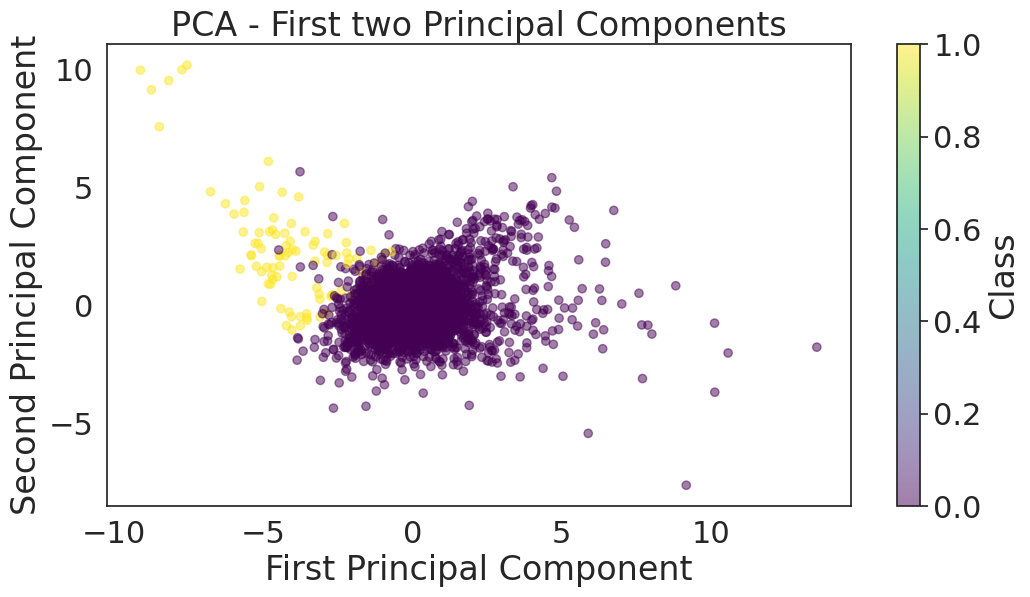

In [43]:
# Plot the first two principal components
plt.figure(figsize=(12, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.5)
plt.colorbar(label='Class')
plt.title('PCA - First two Principal Components')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

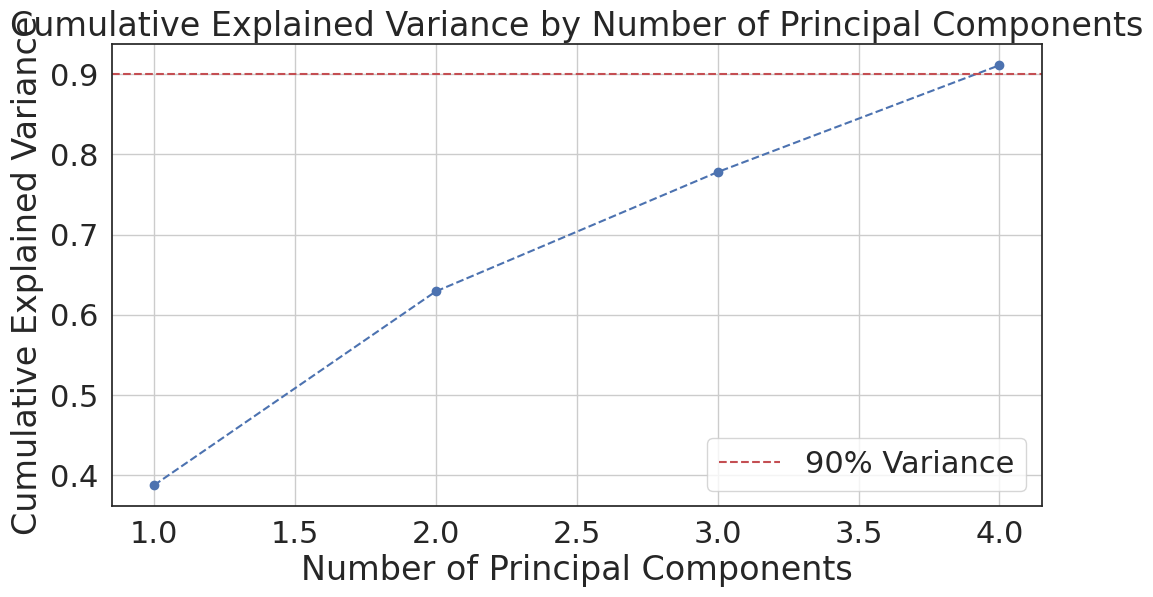

In [44]:
# Plot the cumulative explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Reconstruct the original data from the principal components
X_reconstructed = pca.inverse_transform(X_pca)

In [46]:
# Calculate the reconstruction error for each data point
reconstruction_error = np.mean((X_scaled - X_reconstructed) ** 2, axis=1)
reconstruction_error

array([0.00859724, 0.00960981, 0.01053447, ..., 0.00058196, 0.02528231,
       0.01326592])

In [59]:
# Determine a threshold for identifying anomalies
# For example we selected 95th percentile of the reconstruction errors
threshold = np.percentile(reconstruction_error, 97)

In [60]:
# Identify anomalies based on the reconstruction error
y_pred = (reconstruction_error > threshold).astype(int)

In [61]:
y_pred.sum()

114

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      3679
           1       0.02      0.02      0.02        93

    accuracy                           0.95      3772
   macro avg       0.50      0.50      0.50      3772
weighted avg       0.95      0.95      0.95      3772



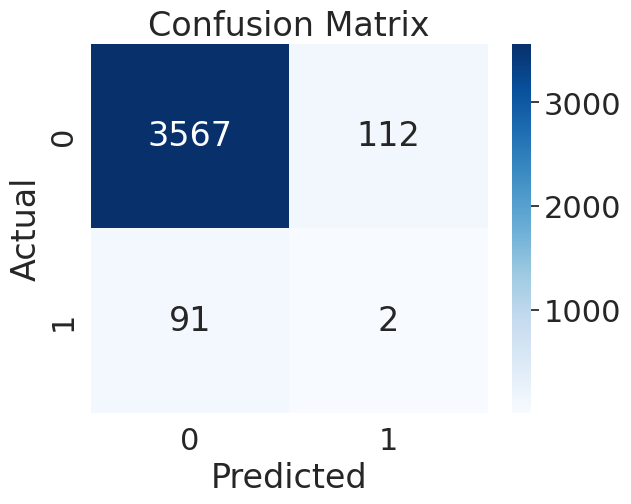

In [62]:
# Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(y, y_pred))
plot_confusion_matrix(y, y_pred)

## AutoEncoder

In [107]:
df = dataframe.copy()
df.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Class
0,0.774194,0.001132,0.137571,0.275701,0.295775,0.236066,0
1,0.247312,0.000472,0.279886,0.329439,0.535211,0.173770,0
2,0.494624,0.003585,0.222960,0.233645,0.525822,0.124590,0
3,0.677419,0.001698,0.156546,0.175234,0.333333,0.136066,0
4,0.236559,0.000472,0.241935,0.320093,0.333333,0.247541,0


In [108]:
print("Distribuition of Normal(0) and Anomaly(1): ")
count_classes = pd.value_counts(df['Class'], sort=True)
count_classes

Distribuition of Normal(0) and Anomaly(1): 


Class
0    3679
1      93
Name: count, dtype: int64

In [109]:
X = df.drop('Class', axis=1)
y = df['Class']

In [137]:
# Standard Scaling for better learning

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [138]:
# First split: training + validation and test sets (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Second split: training and validation sets (75% train, 25% val from the 80% train+val)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [139]:
print(f"train_data_normalised.shape: {X_train.shape}")
print(f"validation_data_normalised.shape: {X_test.shape}")
print(f"test_data_normalised.shape: {X_val.shape}")

train_data_normalised.shape: (2262, 6)
validation_data_normalised.shape: (755, 6)
test_data_normalised.shape: (755, 6)


In [140]:
# lets change the labels with boolean
train_label,validation_label, test_label = y_train.astype(bool), y_val.astype(bool), y_test.astype(bool)

In [141]:
# now  lets seperate the normal and fraud data out of training dataset
normal_train_data = X_train[~train_label] # normal transactions out of train_data_normalised
normal_test_data = X_test[~test_label] # normal transactions out of test_data_normalised
normal_validation_data = X_val[~validation_label]

print(len(normal_train_data))
print(len(normal_test_data))
print(len(normal_validation_data))

2212
736
731


In [142]:
fraud_train_data = X_train[train_label]
fraud_test_data = X_test[test_label]
fraud_validation_data = X_val[validation_label]

print(len(fraud_train_data))
print(len(fraud_test_data))
print(len(fraud_validation_data))

50
19
24


Encoder Design

In [143]:
from tensorflow.keras import models,layers,activations,losses,optimizers,metrics
from tensorflow.keras.callbacks import EarlyStopping

In [144]:
n_features = len(X.columns)
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=200, activation=activations.relu, input_shape=[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer=layers.Dense(units=100, activation=activations.relu))
encoder.add(layer=layers.Dense(units=5, activation=activations.relu))

Decoder Design

In [145]:
decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=100, activation=activations.relu, input_shape=[5]))
decoder.add(layer=layers.Dense(units=200, activation=activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))

In [146]:
autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(loss=losses.MSE, optimizer=optimizers.Adam(), metrics=[metrics.mean_squared_error])

In [147]:
es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=5,restore_best_weights=True)
history = autoencoder.fit(x=normal_train_data, y=normal_train_data, epochs=100, verbose=1, validation_data=(normal_validation_data, normal_validation_data), callbacks=[es])

Epoch 1/100
70/70 [==============================] - 3s 7ms/step - loss: 0.7351 - mean_squared_error: 0.7351 - val_loss: 0.4681 - val_mean_squared_error: 0.4681
Epoch 2/100
70/70 [==============================] - 0s 4ms/step - loss: 0.5270 - mean_squared_error: 0.5270 - val_loss: 0.4550 - val_mean_squared_error: 0.4550
Epoch 3/100
70/70 [==============================] - 0s 5ms/step - loss: 0.5163 - mean_squared_error: 0.5163 - val_loss: 0.4463 - val_mean_squared_error: 0.4463
Epoch 4/100
70/70 [==============================] - 0s 5ms/step - loss: 0.5106 - mean_squared_error: 0.5106 - val_loss: 0.4423 - val_mean_squared_error: 0.4423
Epoch 5/100
70/70 [==============================] - 0s 4ms/step - loss: 0.5075 - mean_squared_error: 0.5075 - val_loss: 0.4418 - val_mean_squared_error: 0.4418
Epoch 6/100
70/70 [==============================] - 0s 4ms/step - loss: 0.5073 - mean_squared_error: 0.5073 - val_loss: 0.4382 - val_mean_squared_error: 0.4382
Epoch 7/100
70/70 [===============

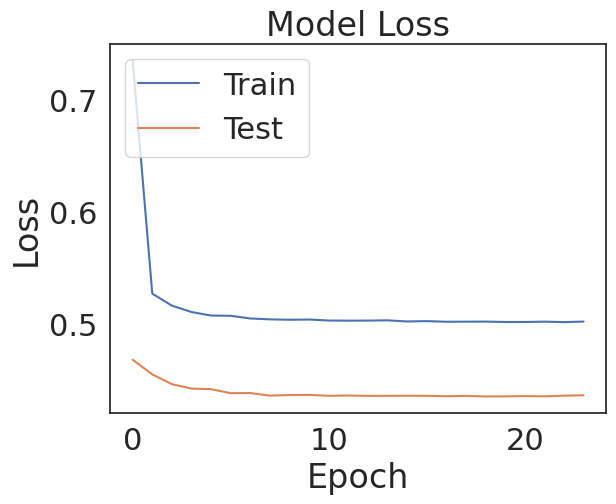

In [148]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [149]:
# Define a function in order to plot the original ECG and reconstructed ones and also show the error
def plot(data, n):
  dec_img = autoencoder.predict(data) # this will decode or reconstruct
  plt.plot(data[n], 'b')
  plt.plot(dec_img[n], 'r')
  plt.fill_between(np.arange(plot_dim), data[n], dec_img[n], color = 'lightcoral')
  plt.legend(labels=['Input', 'Reconstruction', 'Error'])
  plt.show()

23/23 [==============================] - 0s 3ms/step


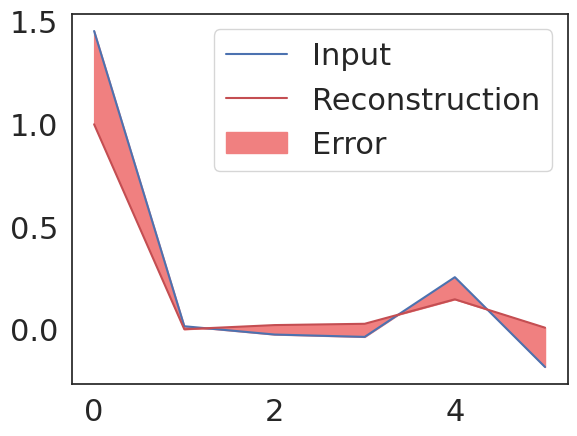

1/1 [==============================] - 0s 86ms/step


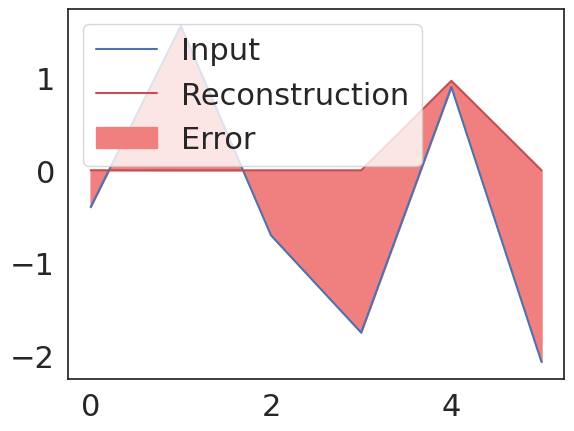

In [150]:
plot(normal_test_data, 4) # here n shows the index of ecg samples
plot(fraud_test_data, 4)

70/70 [==============================] - 0s 2ms/step
0.401369973166546


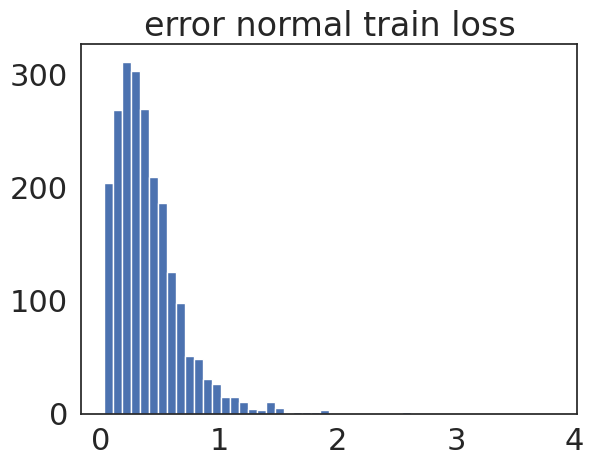

In [151]:
### calculating the train error  in legit transactions
reconstructed = autoencoder.predict(normal_train_data)
train_normal_loss = losses.mae(reconstructed, normal_train_data).numpy()
print(np.mean(train_normal_loss))

plt.hist(train_normal_loss, bins = 50)
plt.title('error normal train loss')
plt.show()

2/2 [==============================] - 0s 6ms/step
1.8660471395877698


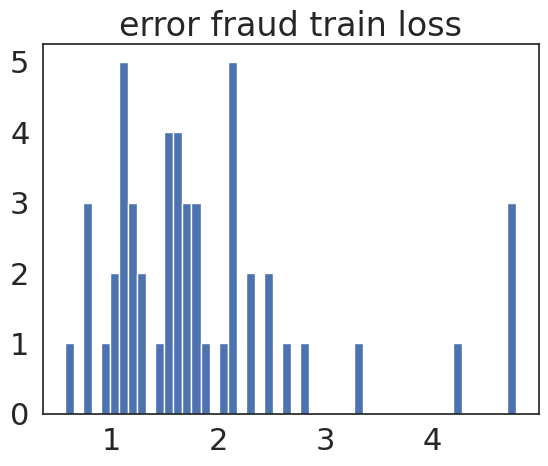

In [152]:
### calculating the train error  in fraud transactions
reconstructed = autoencoder.predict(fraud_train_data)
train_fraud_loss = losses.mae(reconstructed, fraud_train_data).numpy()
print(np.mean(train_fraud_loss))
plt.hist(train_fraud_loss, bins = 50)
plt.title('error fraud train loss')
plt.show()

In [153]:
Fraud = df.Class.sum()
total = len(df)
fraud_percentage = (Fraud/total)*100
fraud_percentage
# so lets say that 1% of transactions are fraud so lets find the threshold

2.4655355249204667

In [154]:
# calcualting the error in the whole train data
reconstructed = autoencoder.predict(X_train)
train_loss = losses.mae(reconstructed, X_train).numpy()

71/71 [==============================] - 0s 2ms/step


In [178]:
# we are assuming that we have 3% of fraud transaction here
cut_off_1 = np.percentile(train_loss, 97.25)
cut_off_1

1.4312006950841234

In [179]:
cut_off_2 = np.mean(train_loss) + 5*np.std(train_loss)
cut_off_2
# 2std division covers 97% of the distribution and here i have taken 3 std division

2.4984109141857944

In [180]:
reconstructed = autoencoder.predict(X_test)
errors = losses.mae(reconstructed, X_test)
len(errors)
predicted = []
for error in errors:
    if error > cut_off_1:
        predicted.append(1)
    else:
        predicted.append(0)

24/24 [==============================] - 0s 4ms/step


In [181]:
np.sort(errors)[::-1]

array([4.86019559, 2.61152773, 2.49323009, 2.19705024, 2.05688826,
       1.88143138, 1.8790618 , 1.82018196, 1.76247876, 1.74161931,
       1.7251783 , 1.69474677, 1.64161177, 1.62121317, 1.54553471,
       1.53228216, 1.48638354, 1.48539921, 1.4614204 , 1.43443964,
       1.41117134, 1.40062771, 1.39827178, 1.31761728, 1.30861973,
       1.27284093, 1.27065273, 1.23373486, 1.18239174, 1.17715549,
       1.10903116, 1.10478185, 1.08866132, 1.07949506, 1.07867841,
       1.0639775 , 1.01911497, 0.99715074, 0.99425511, 0.97636314,
       0.97480278, 0.9745509 , 0.97157742, 0.93230922, 0.91116512,
       0.90878019, 0.90144853, 0.89838182, 0.89355213, 0.8895787 ,
       0.87958155, 0.87581053, 0.87322019, 0.87177561, 0.87073887,
       0.86260015, 0.86005095, 0.85370191, 0.85079666, 0.85052851,
       0.84928165, 0.83600237, 0.83189798, 0.83085867, 0.8223772 ,
       0.82048938, 0.81682135, 0.80971114, 0.80891168, 0.80768512,
       0.7934107 , 0.79310323, 0.7909826 , 0.78741251, 0.77872

In [182]:
predicted_fraud_cases = np.array(predicted).sum()
actual_fraud_cases = test_label.sum()
print('predicted_fruad_cases =>'.format(), predicted_fraud_cases, 'true fraud cases =>'.format(), actual_fraud_cases)

predicted_fruad_cases => 20 true fraud cases => 19


In [183]:
# From booliean Map back to 1 and 0
true_label = test_label.map({True:1,False:0})

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       736
           1       0.60      0.63      0.62        19

    accuracy                           0.98       755
   macro avg       0.80      0.81      0.80       755
weighted avg       0.98      0.98      0.98       755



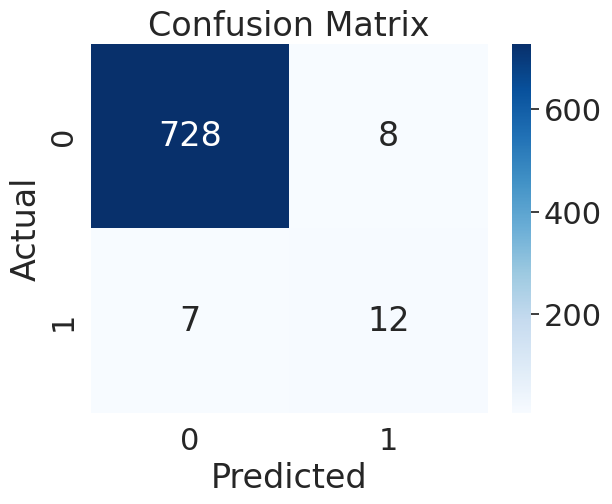

In [184]:
### classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(true_label, predicted))
plot_confusion_matrix(true_label, predicted)

##  DBSCAN

In [185]:
df = dataframe.copy()

In [186]:
X = df.drop('Class', axis=1)
y = df['Class']

In [187]:
# here we are going to use min max scaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

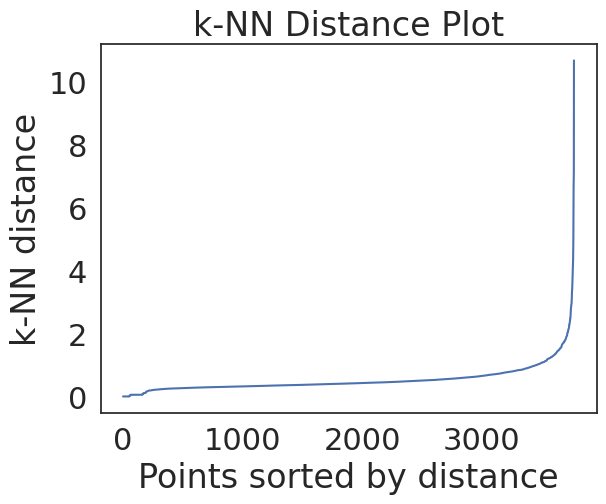

In [188]:
from sklearn.neighbors import NearestNeighbors

# Step 1: Calculate the k-nearest neighbors
k = 5  # k is usually set to min_samples - 1
nearest_neighbors = NearestNeighbors(n_neighbors=k)
neighbors = nearest_neighbors.fit(X_scaled)
distances, indices = neighbors.kneighbors(X_scaled)

# Step 2: Sort the distances (4th column)
distances = np.sort(distances[:, k-1], axis=0)

# Step 3: Plot the distances
plt.plot(distances)
plt.ylabel('k-NN distance')
plt.xlabel('Points sorted by distance')
plt.title('k-NN Distance Plot')
plt.show()

# The "elbow" point is a good candidate for `eps`

In [268]:
from sklearn.cluster import DBSCAN

# Create DBSCAN object
dbscan = DBSCAN(eps=1.5, min_samples=15)

In [269]:
# Fitting the model
model = dbscan.fit(X_scaled)

In [270]:
# classification result as labels
labels = model.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

In [271]:
# Find unique values
unique_values = np.unique(labels)

# Print unique values
print(unique_values)

[-1  0]


In [272]:
# Consider all nodes belonging to -1 as outliers
outlier_indices = np.where(labels == -1)[0]
print(len(outlier_indices))

140


In [273]:
#Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
prediction = np.where(labels == -1, 1, 0)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3679
           1       0.39      0.59      0.47        93

    accuracy                           0.97      3772
   macro avg       0.69      0.78      0.73      3772
weighted avg       0.97      0.97      0.97      3772



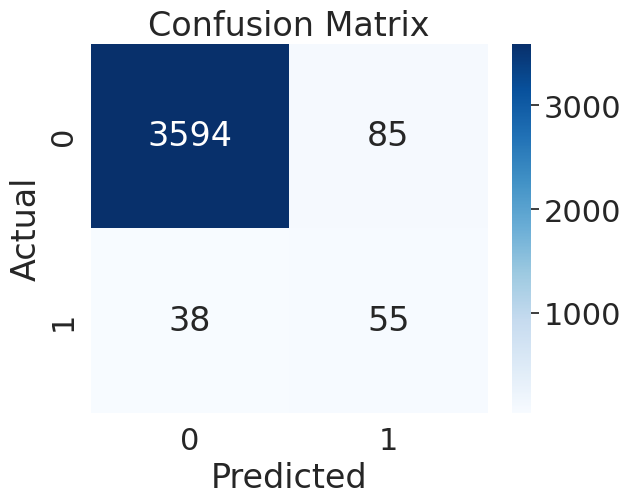

In [274]:
### classification report
print(classification_report(y, prediction))
plot_confusion_matrix(y, prediction)

## GMM

In [288]:
df = dataframe.copy()

In [291]:
# Count anonalies (outlier_label = 1)
num_fraudulent = df['Class'].value_counts().get(1, 0)

# Count normal vales (outlier_label = 0)
num_normal = df['Class'].value_counts().get(0, 0)

# Calculate the ratio
if num_normal > 0:
    ratio = num_fraudulent / num_normal
else:
    ratio = float('inf')  # Avoid division by zero if there are no normal transactions

print(f'Number of fraudulent transactions: {num_fraudulent}')
print(f'Number of normal transactions: {num_normal}')
print(f'Ratio of fraudulent to normal transactions: {ratio: f}')

Number of fraudulent transactions: 93
Number of normal transactions: 3679
Ratio of fraudulent to normal transactions:  0.025279


In [292]:
y = df['Class']
X = df.drop(['Class'], axis=1)

# Only include normal data
X_normal = Normal.drop(['Class'], axis=1)
Y_normal = Anomaly.drop(['Class'], axis=1)

In [297]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [298]:
# # Split the data into test and validation sets with a 50-50 split
# X_test, X_validate, y_test, y_validate = train_test_split(X_scaled, y, test_size=0.5, random_state=42)

# print("Shape of X_test:", X_test.shape)
# print("Shape of y_test:", y_test.shape)
# print("Shape of X_validate:", X_validate.shape)
# print("Shape of y_validate:", y_validate.shape)

In [299]:
from sklearn.mixture import GaussianMixture

# Define the range for n_components
n_components_range = range(1, 11)

# Lists to store the BIC and AIC scores
bic_scores = []
aic_scores = []

# Fit GMM for each n_components and calculate BIC and AIC
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, n_init=5, random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))

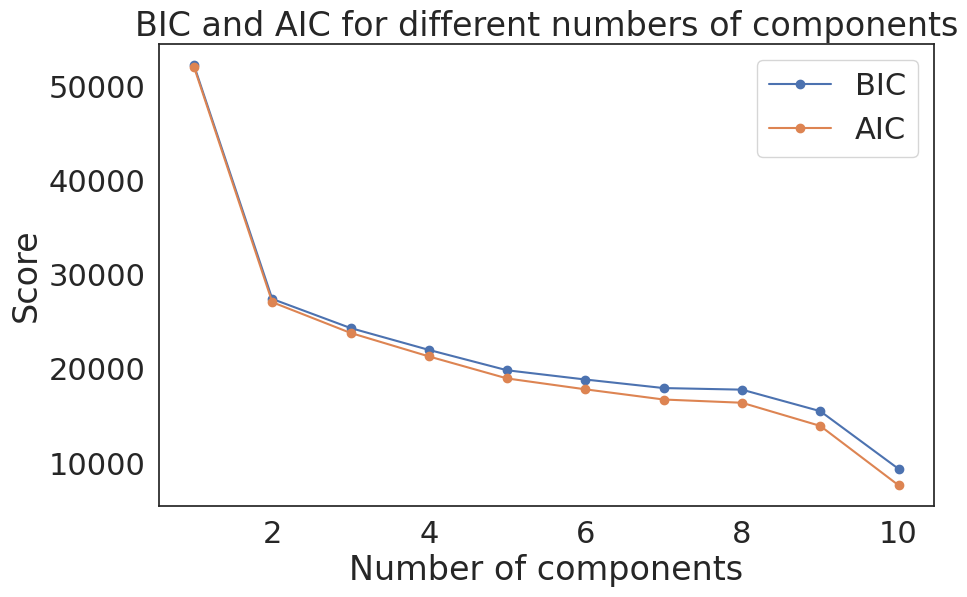

In [300]:
# Plot BIC and AIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, label='BIC', marker='o')
plt.plot(n_components_range, aic_scores, label='AIC', marker='o')
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('BIC and AIC for different numbers of components')
plt.legend()
plt.show()

In [301]:
# Fit GMM model
gmm = GaussianMixture(n_components=10, n_init=10, random_state=42)
gmm.fit(X_scaled)

GaussianMixture(n_components=10, n_init=10, random_state=42)

In [302]:
score_for_normal = gmm.score_samples(X_scaled)

In [303]:
# Compute scores
y_predict = gmm.predict(X_scaled)
score = gmm.score_samples(X_scaled)
X['score'] = score
X.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,score
0,0.774194,0.001132,0.137571,0.275701,0.295775,0.236066,-1.102544
1,0.247312,0.000472,0.279886,0.329439,0.535211,0.173770,-3.851628
2,0.494624,0.003585,0.222960,0.233645,0.525822,0.124590,-5.259106
3,0.677419,0.001698,0.156546,0.175234,0.333333,0.136066,0.325880
4,0.236559,0.000472,0.241935,0.320093,0.333333,0.247541,-2.609770


In [310]:
# Determine threshold for anomalies
threshold = np.percentile(score_for_normal, 3)
print(f'The threshold of the score is {threshold:.2f}')

The threshold of the score is -11.13


In [311]:
# Assign anomaly labels based on the threshold
X['predicted_class'] = (X['score'] < threshold).astype(int)

In [312]:
len(X[X['predicted_class']==1])

114

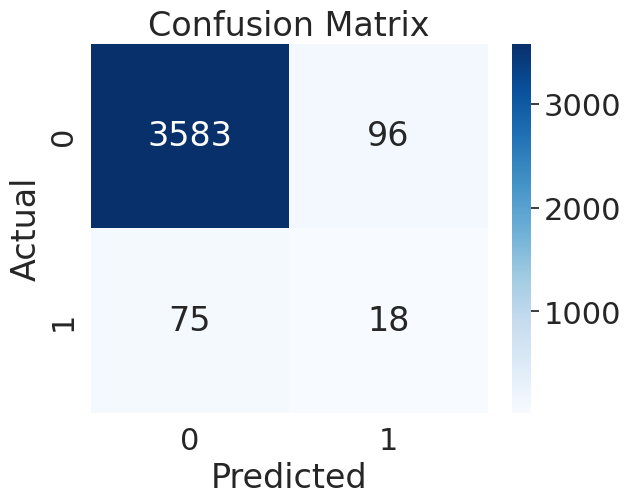

In [314]:
plot_confusion_matrix(y, X['predicted_class'])

In [315]:
# Generate classification report
class_report = classification_report(y, X['predicted_class'])
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      3679
           1       0.16      0.19      0.17        93

    accuracy                           0.95      3772
   macro avg       0.57      0.58      0.58      3772
weighted avg       0.96      0.95      0.96      3772



## Histogram Based Outlier Score

In [316]:
df = dataframe.copy()

In [317]:
df.head()

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Class
0,0.774194,0.001132,0.137571,0.275701,0.295775,0.236066,0
1,0.247312,0.000472,0.279886,0.329439,0.535211,0.173770,0
2,0.494624,0.003585,0.222960,0.233645,0.525822,0.124590,0
3,0.677419,0.001698,0.156546,0.175234,0.333333,0.136066,0
4,0.236559,0.000472,0.241935,0.320093,0.333333,0.247541,0


In [318]:
# Seperate feature from target
X = df.drop('Class', axis=1)
y = df['Class']

In [319]:
# Scale the feature value
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [322]:
from pyod.models.hbos import HBOS

# Initialize HBOS
hbos = HBOS(contamination=outlier_fraction, n_bins=20)

# Fit HBOS to the data
hbos.fit(X_scaled)

HBOS(alpha=0.1, contamination=0.025278608317477577, n_bins=20, tol=0.5)

In [323]:
# Predict the outliers
y_pred = hbos.labels_  # binary labels (0: inliers, 1: outliers)
y_scores = hbos.decision_scores_  # raw outlier scores

In [324]:
# Get the unique values and their counts
values, counts = np.unique(y_pred, return_counts=True)

# Print the count of each value
for value, count in zip(values, counts):
    print(f"Value {value} appears {count} times")

Value 0 appears 3676 times
Value 1 appears 96 times


In [325]:
print("\nClassification Report:")
print(classification_report(y, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3679
           1       0.66      0.68      0.67        93

    accuracy                           0.98      3772
   macro avg       0.82      0.83      0.83      3772
weighted avg       0.98      0.98      0.98      3772



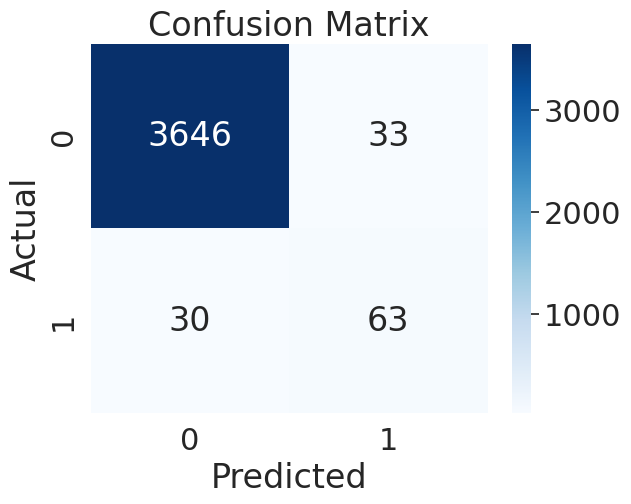

In [326]:
plot_confusion_matrix(y, y_pred)

## Isolation Forest

In [365]:
df = dataframe.copy()

In [366]:
# split train and label
x = df.drop('Class', axis = 1)
y = df['Class']

In [367]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y , test_size = 0.2, random_state = 42)
x_train = Normal.drop('Class', axis = 1) # remake x_train with only normal data

In [368]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators=100, bootstrap=True, random_state=42)
iforest.fit(x_train)

IsolationForest(bootstrap=True, random_state=42)

In [369]:
y_pred1 = iforest.predict(x_test)
y_pred1 = np.where(y_pred1 == 1, 0, 1) # normal = 1, anomaly = 0
y_pred2 = iforest.decision_function(x_test) # negative : outliers, positive : inliers

Printing the classification report with fixed parameters...
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       736
           1       0.21      1.00      0.35        19

    accuracy                           0.91       755
   macro avg       0.61      0.95      0.65       755
weighted avg       0.98      0.91      0.93       755

Printing the confusion matrix with fixed parameters...


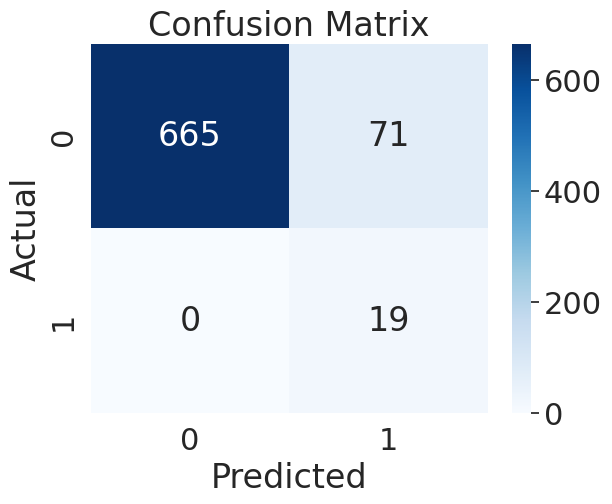

In [370]:
print("Printing the classification report with fixed parameters...")
print(classification_report(y_test, y_pred1))
print("Printing the confusion matrix with fixed parameters...")
plot_confusion_matrix(y_test, y_pred1)

## KMeans

In [371]:
df = dataframe.copy()

In [372]:
# Separate features and target variable
X = df.drop('Class', axis=1)
y = df['Class']

In [373]:
# Assuming X is your original DataFrame
# Scale the data with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back into a DataFrame with the original column names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

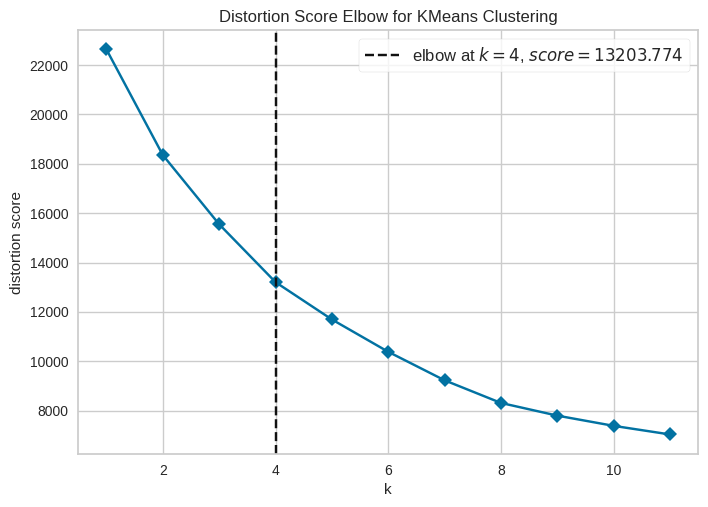

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [374]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12),  timings=False)

visualizer.fit(X_scaled_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [384]:
# Set the optimal number of clusters (based on the ElbowVisualizer output)
# optimal_clusters = visualizer.elbow_value_
optimal_clusters = 3

In [385]:
if optimal_clusters is None:
    print("No optimal number of clusters found.")
    optimal_clusters = 5
else:
    print(f"Optimal number of clusters: {optimal_clusters}")

Optimal number of clusters: 3


In [386]:
# Apply KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X_scaled_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [387]:
# Predict clusters
clusters = kmeans.predict(X_scaled_df)

In [388]:
# Map clusters to labels by finding the majority label in each cluster
cluster_labels = {}
for cluster in range(optimal_clusters):
    mask = clusters == cluster
    majority_label = y[mask].mode()[0]  # Get the majority label
    cluster_labels[cluster] = majority_label

In [393]:
# Identify the cluster with the highest number of anomaly '1' classes
# anomaly_cluster = max(cluster_labels, key=cluster_labels.get)
anomaly_cluster = 1

In [394]:
# Generate predictions based on the identified cluster
y_pred = np.array([1 if cluster == anomaly_cluster else 0 for cluster in clusters])

<Figure size 1200x800 with 0 Axes>

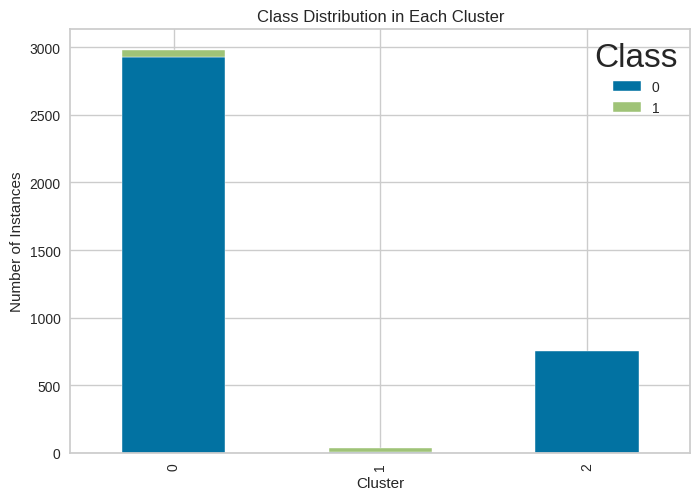

In [395]:
# Create a DataFrame for cluster and class labels
cluster_class_df = pd.DataFrame({'Cluster': clusters, 'Class': y})

# Plot class distribution in each cluster
plt.figure(figsize=(12, 8))
cluster_class_dist = cluster_class_df.groupby(['Cluster', 'Class']).size().unstack(fill_value=0)
cluster_class_dist.plot(kind='bar', stacked=True)
plt.title('Class Distribution in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Instances')
plt.legend(title='Class', loc='upper right')
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3679
           1       0.89      0.37      0.52        93

    accuracy                           0.98      3772
   macro avg       0.94      0.68      0.76      3772
weighted avg       0.98      0.98      0.98      3772



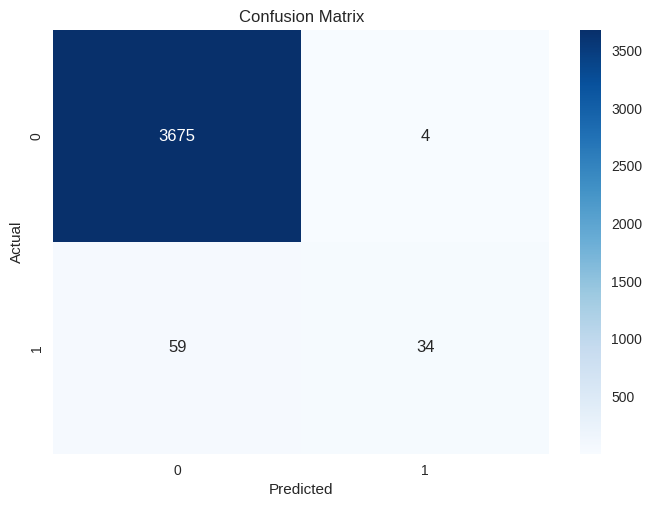

In [396]:
# Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(y, y_pred))
plot_confusion_matrix(y, y_pred)

## Local Otlier Factor

In [397]:
df = dataframe.copy()

In [398]:
# Seperate labels from target
X = dataframe.drop('Class', axis=1)
y = dataframe['Class']

In [399]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [464]:
from sklearn.neighbors import LocalOutlierFactor

# Works just like K-nearest neighbor so n_neighbour parameter stands for no. of neighbors we have to search for a datapoint
# contamination parameter influences how aggressively the LOF algorithm identifies outliers
LOF_classifier = LocalOutlierFactor(n_neighbors=100, algorithm='auto', metric='minkowski',
                   p=2, metric_params=None, contamination=0.05)

In [465]:
y_pred = LOF_classifier.fit_predict(X_scaled)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [466]:
# Higher the lower the value(keep in my values are negative) higher the chance of it being outlier
score_prediction = LOF_classifier.negative_outlier_factor_
score_prediction

array([-1.09466889, -1.09949434, -1.21823221, ..., -1.33134194,
       -1.09346506, -1.01324244])

In [467]:
outlier_indices = np.where(y_pred == -1)[0]
print(len(outlier_indices))

189


In [468]:
# !! CAREFUL RUN ONLY ONCE
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1

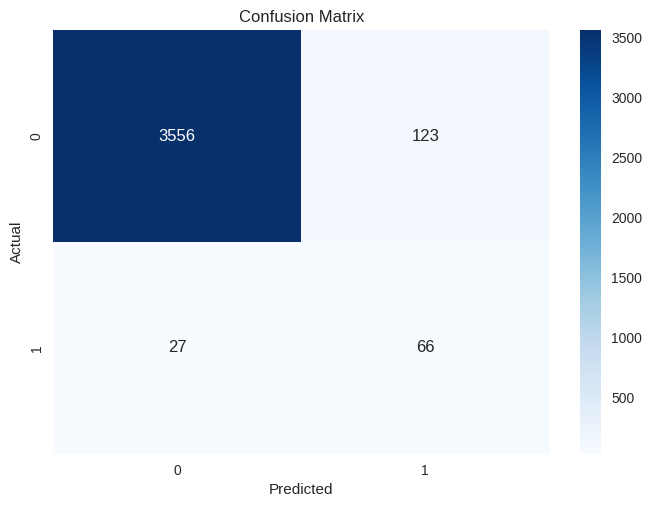

In [469]:
plot_confusion_matrix(y, y_pred)

In [470]:
print("Accuracy Score :", accuracy_score(y, y_pred))
print("Classification Report :")
print(classification_report(y, y_pred))

Accuracy Score : 0.9602332979851538
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3679
           1       0.35      0.71      0.47        93

    accuracy                           0.96      3772
   macro avg       0.67      0.84      0.72      3772
weighted avg       0.98      0.96      0.97      3772



## One-Class SVM

In [471]:
df = dataframe.copy()

In [472]:
X = df.drop('Class', axis=1)
y = df['Class']

In [474]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [475]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

print(f'There are {X_train.shape[0]} samples in the training set and {X_test.shape[0]} samples in the test set.')

There are 2640 samples in the training set and 1132 samples in the test set.


In [476]:
# Train One-Class SVM on normal transactions only
X_train_normal = X_train[y_train == 0]

In [506]:
from sklearn.svm import OneClassSVM

# Initialise OneClassSVM class
ocsvm = OneClassSVM(kernel='rbf', nu=0.01, gamma='auto')

In [507]:
# Fiting the data
ocsvm.fit(X_train_normal)

OneClassSVM(gamma='auto', nu=0.01)

In [508]:
# Check number of anomaly in  y test
len(y_test[y_test == 1])

34

In [509]:
# Predict on the test set
y_pred = ocsvm.predict(X_test)

In [510]:
# Map predictions to 0 for normal and 1 for anomaly to match the original labels
y_pred = [1 if x == -1 else 0 for x in y_pred]

In [511]:
anomalies_count = sum(y_pred)
print("Number of anomalies predicted:", anomalies_count)

Number of anomalies predicted: 65


In [512]:
print("Classification Report: ")
print(classification_report(y_test, y_pred))

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1098
           1       0.38      0.74      0.51        34

    accuracy                           0.96      1132
   macro avg       0.69      0.85      0.74      1132
weighted avg       0.97      0.96      0.96      1132



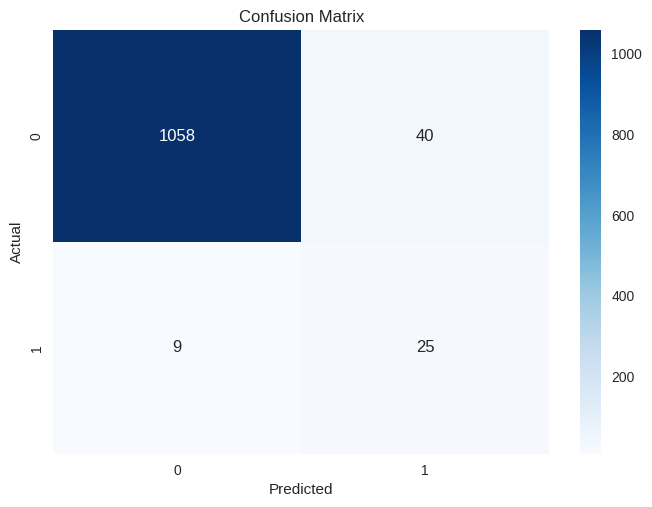

In [513]:
plot_confusion_matrix(y_test, y_pred)

## Minimum Covariance Determinant

In [514]:
df = dataframe.copy()

In [515]:
X = df.drop('Class', axis=1)
y = df['Class']

In [516]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 1.13402698, -0.17855046, -0.69968517,  0.33969626, -0.92898752,
         1.07040655],
       [-1.45172717, -0.19356858,  1.32194594,  1.00668962,  1.81147723,
        -0.06430572],
       [-0.23800583, -0.12276883,  0.5132935 , -0.18229855,  1.70400802,
        -0.9601312 ],
       ...,
       [ 1.92558437,  0.35352043, -0.37622419,  0.42669539, -0.01549927,
         0.41346787],
       [ 0.65909254, -0.17082685,  0.05505711, -0.06629971, -0.6065799 ,
         0.32388532],
       [-0.29077633, -0.12319792,  0.05505711, -0.44329596, -0.44537609,
        -0.24347081]])

In [517]:
from pyod.models.mcd import MCD

mcd_detector = MCD(contamination=outlier_fraction, support_fraction=1, random_state=42)

In [518]:
# Fit the model
mcd_detector.fit(X_scaled)

MCD(assume_centered=False, contamination=0.025278608317477577,
  random_state=42, store_precision=True, support_fraction=1)

In [519]:
# Get the prediction
mcd_pred = mcd_detector.predict(X_scaled)
# Get the decision scores
mcd_scores = mcd_detector.decision_scores_

In [520]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, f1_score, adjusted_rand_score, mutual_info_score, precision_recall_curve, auc
# Calculate ROC AUC
roc_auc = roc_auc_score(y, mcd_scores)
f1 = f1_score(y, mcd_pred)
ari = adjusted_rand_score(y, mcd_pred)
mi_score = mutual_info_score(y, mcd_pred)

In [521]:
print("ROC AUC Score:", roc_auc)
print("F1 Score:", f1)
print("Adjusted Rand Index:", ari)
print("Mutual Information Score:", mi_score)

ROC AUC Score: 0.9721815476973348
F1 Score: 0.5079365079365079
Adjusted Rand Index: 0.4824493944881041
Mutual Information Score: 0.03361715267737136


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3679
           1       0.50      0.52      0.51        93

    accuracy                           0.98      3772
   macro avg       0.74      0.75      0.75      3772
weighted avg       0.98      0.98      0.98      3772

Recall score: 0.5161290322580645


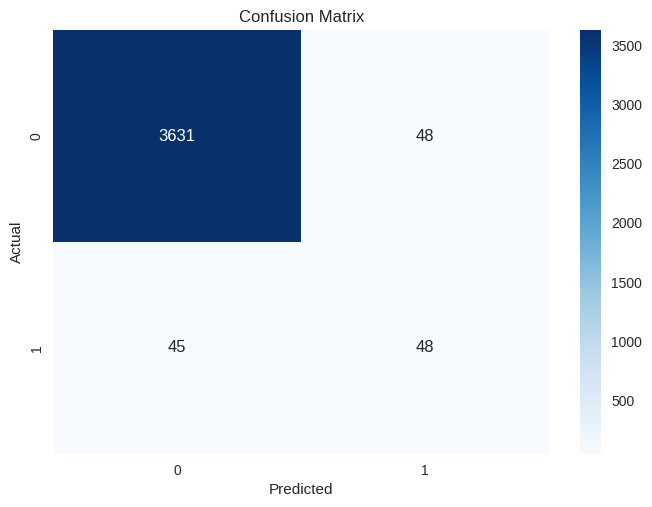

In [522]:
print(classification_report(y, mcd_pred))
print(f"Recall score: {recall_score(y, mcd_pred)}")

plot_confusion_matrix(y, mcd_pred)

Check wheather this will work with only boolean data